In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from tqdm import tqdm
import re
import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
train = pd.read_csv('dataset/train.csv', low_memory=False)
test = pd.read_csv('dataset/test.csv', low_memory=False)

In [3]:
train.shape

(404290, 6)

In [4]:
test.shape

(3563475, 3)

In [5]:
train.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [6]:
tqdm.pandas()

### 1. Distribution of the class labels

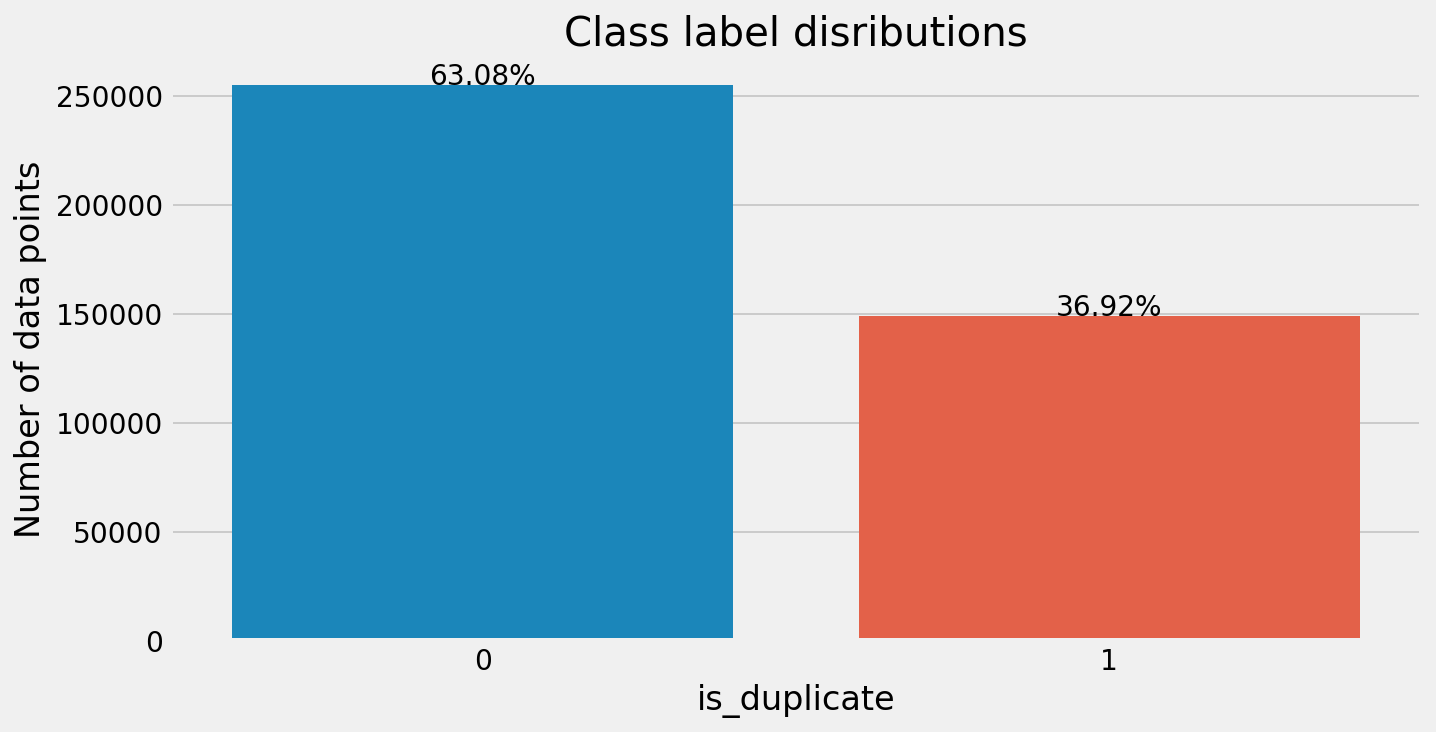

In [9]:
ax = sns.countplot(train.is_duplicate);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/train.shape[0]) * 100.0),
            ha="center")
plt.title('Class label disributions');
plt.ylabel('Number of data points');

- **Note 1:** Class labes are skewed but not too much. Hence primary steps for unbalanced datasets are good enough. Upsampling/downsampling might not be required

### 2. Null Values

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563475 entries, 0 to 3563474
Data columns (total 3 columns):
test_id      object
question1    object
question2    object
dtypes: object(3)
memory usage: 81.6+ MB


We can see that in ourtraining dataset for the column `question1` 1 row is null and for `question2` 2 rows are null. Let's see these rows

In [12]:
train[pd.isna(train.question2)]

id    qid1    qid2                         question1 question2  \
105780  105780  174363  174364    How can I develop android app?       NaN   
201841  201841  303951  174364  How can I create an Android app?       NaN   

        is_duplicate  
105780             0  
201841             0

This two question seems to be duplicate of each other. So I shall do daisy chaining for the ```question_2```.

In [13]:
train.loc[105780, 'question2'] = train.loc[201841, 'question1']
train.loc[201841, 'question2'] = train.loc[105780, 'question1']

In [14]:
train.loc[[105780, 201841], 'is_duplicate'] = 1

In [15]:
train.loc[[105780, 201841]]

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   

                               question2  is_duplicate  
105780  How can I create an Android app?             1  
201841    How can I develop android app?             1

In [16]:
train[pd.isna(train.question1)]

id    qid1    qid2 question1  \
363362  363362  493340  493341       NaN   

                                                question2  is_duplicate  
363362  My Chinese name is Haichao Yu. What English na...             0

For this I am choosing to drop the question as we have enough data points, loosing one row won't make much of a difference

In [17]:
train.dropna(inplace=True)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404289 entries, 0 to 404289
Data columns (total 6 columns):
id              404289 non-null int64
qid1            404289 non-null int64
qid2            404289 non-null int64
question1       404289 non-null object
question2       404289 non-null object
is_duplicate    404289 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


### 3. Make all the characters lower case

In [19]:
def make_lower(x):
    if x == x:  # np.nan != np.nan
        return x.lower()
    else:
        return x

In [20]:
train['question1'] = train.question1.progress_apply(make_lower)
train['question2'] = train.question2.progress_apply(make_lower)
test['question1'] = test.question1.progress_apply(make_lower)
test['question2'] = test.question2.progress_apply(make_lower)

100%|██████████| 3563475/3563475 [00:12<00:00, 295689.25it/s]


### 4. Repeated Questions Pairs

In [21]:
reaps = train[train.duplicated(subset=['question1', 'question2'], keep=False)]

In [22]:
reaps.head()

id  qid1  qid2                                          question1  \
71      71   143   144       what is a narcissistic personality disorder?   
250    250   501   502           how can you recover your gmail password?   
517    517  1032  1033  what are the major differences between chinese...   
1806  1806  3595  3596                              how do i lose weight?   
2010  2010  3999  4000  what are the major differences between chinese...   

                                              question2  is_duplicate  
71           what is narcissistic personality disorder?             1  
250   i do not remember my password to my gmail acco...             1  
517   what is the difference between chinese and wes...             1  
1806               how do i suck it up and lose weight?             1  
2010  what the difference between western culture an...             1

In [23]:
reaps.shape[0] / train.shape[0] * 100

0.17017529539512577

In [24]:
counts = {}

for id, q1, q2 in tqdm(zip(reaps.id, reaps.question1, reaps.question2)):
    c = train[(train.question1 == q1) & (train.question2 == q2)].shape[0]
    counts[id] = c



688it [01:53,  6.05it/s]


In [25]:
np.unique(list(counts.values())) # Different number or repetations

array([2, 3, 4])

#### Distribution of class labels for repeated questions

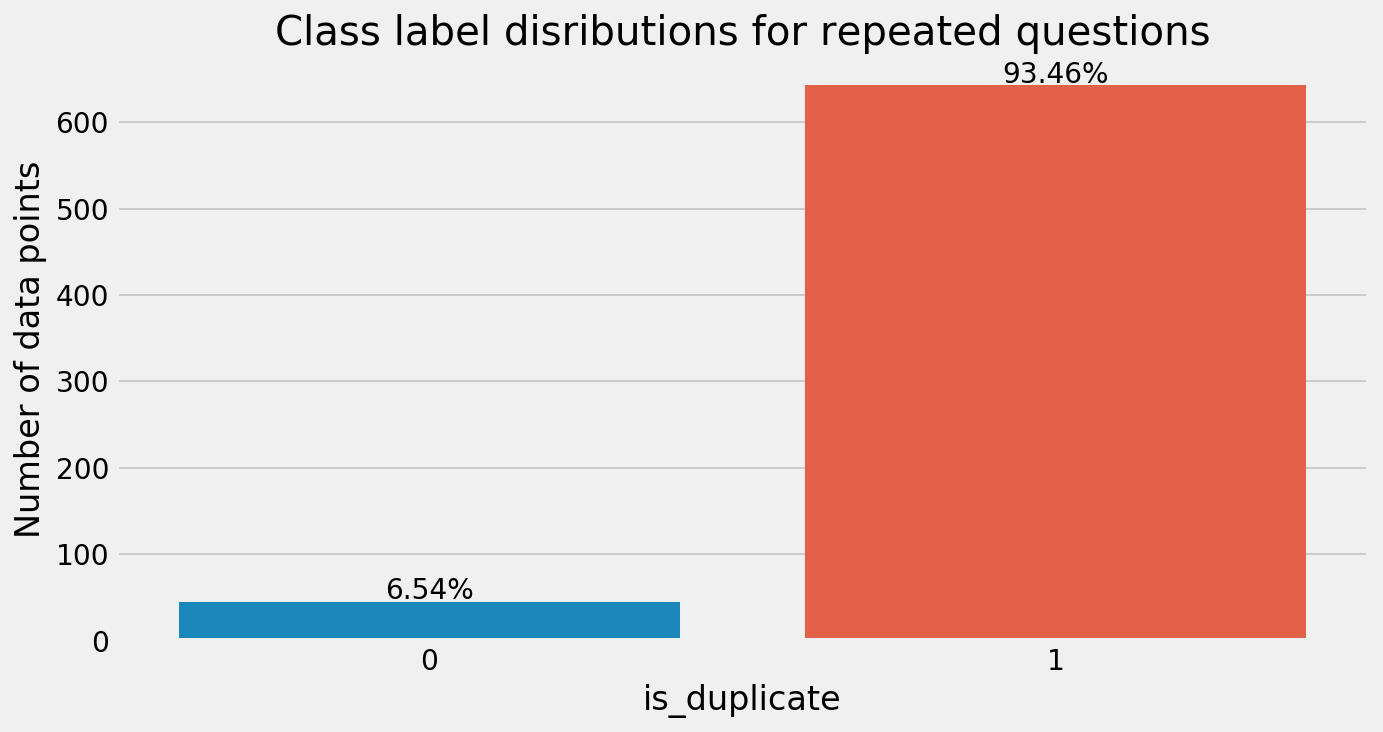

In [26]:
ax = sns.countplot(reaps.is_duplicate);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/reaps.shape[0]) * 100.0),
            ha="center")
plt.title('Class label disributions for repeated questions');
plt.ylabel('Number of data points');

- **Note:** Almost 94% of the question pairs that are repeated is of class label 1. This means a feature named `pair_repeats` representing number of times pair or question1 and question2 repeats is going to be an important features.

In [27]:
def get_pair_repeat_counts(row):
    global counts
    return counts.get(row.id, 0)

In [28]:
train['pair_repeats'] = train.apply(get_pair_repeat_counts, axis=1)

### 5. Repeated Questions Indivisual

In [29]:
reapet_q1 = train[train.duplicated(subset=['question1'], keep=False)].id
train['q1_repeated'] = 0
train.loc[train.index.isin(reapet_q1.index), 'q1_repeated'] = 1

/home/paperspace/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


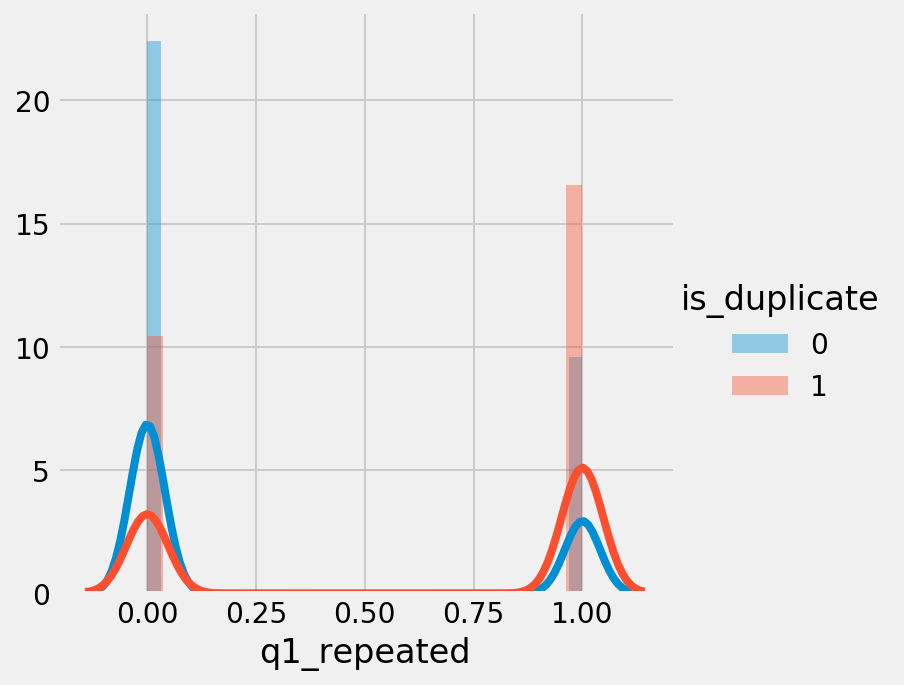

In [30]:
sns.FacetGrid(train, hue='is_duplicate', height=5).map(sns.distplot, 'q1_repeated').add_legend();

- **Note:** Repeating question 1 doesn't make much of a effect for duplicate questions

### 6. Basic Feature Extraction (before cleaning)

##### freq_qid1 - How many times question 1 is repeated

In [31]:
train['freq_qid1'] = train.groupby('qid1').qid1.transform('count')

##### freq_qid2 - How many times question 2 s repeated

In [32]:
train['freq_qid2'] = train.groupby('qid2').qid1.transform('count')

##### q1len - Length of of the question 1

In [33]:
train['q1len'] = train.question1.str.len()

##### q2len - Length of of the question 2

In [34]:
train['q2len'] = train.question2.str.len()

##### q1_n_words - Number of total words in question 1

In [35]:
train['q1_n_words'] = train.question1.apply(lambda x: len(x.split()))

##### q2_n_words - Number of total words in question 2

In [36]:
train['q2_n_words'] = train.question2.apply(lambda x: len(x.split()))

##### word_Common - Common but unique words in both questions

In [3]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [38]:
train['word_Common'] = train.apply(lambda row: 
                                   len(set(tokenizer.tokenize(row.question1)) & 
                                       set(tokenizer.tokenize(row.question2))),
                                   axis=1)

##### word_Total - Total number of UNIQUE words in question 1 and question 2

In [39]:
train['word_Total']= train.progress_apply(lambda row: 
                                   len(set(tokenizer.tokenize(row.question1))) +
                                   len(set(tokenizer.tokenize(row.question2))),
                                   axis=1)

100%|██████████| 404289/404289 [00:45<00:00, 8869.15it/s] 


##### word_share - word_Common / word_Total

In [40]:
train['word_share'] = train.word_Common / train.word_Total

In [41]:
train['freq_q1_n_q2'] = train.freq_qid1 + train.freq_qid2

In [42]:
train['freq_q1_m_q2'] = abs(train.freq_qid1 - train.freq_qid2)

#### Checkpoint 1

In [180]:
conn = sqlite3.connect('dataset/Cleaned.db')
train.to_sql('train', conn, if_exists='replace', index=False)
conn.close()

#### Loading the dataset

In [3]:
with sqlite3.connect('dataset/Cleaned.db') as conn:
    train = pd.read_sql_query('SELECT * FROM train', conn)

### 7. Analysis of some of the extracted features

#### Impact of word_share

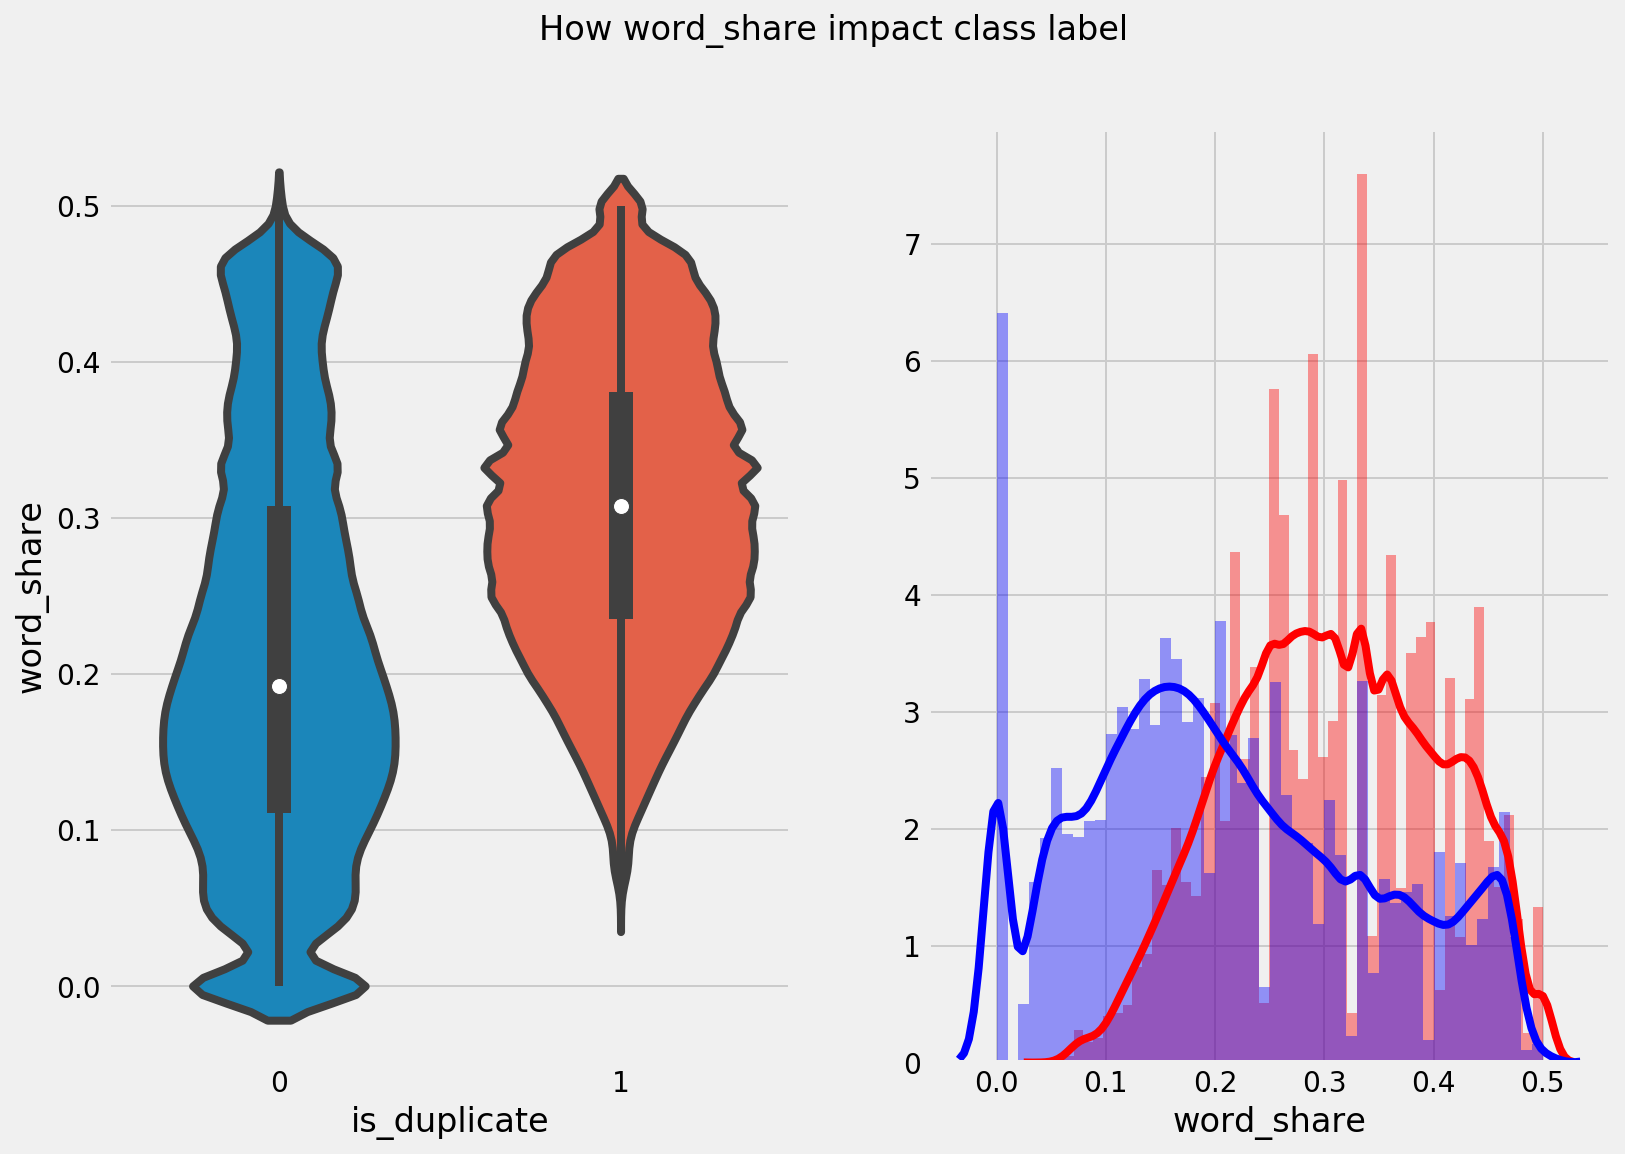

In [46]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train[0:])
plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.suptitle('How word_share impact class label')
plt.show()

### 8. Text Preprocessing

In [17]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
tokenizer = RegexpTokenizer(r'\w+')

In [8]:
from stanfordcorenlp import StanfordCoreNLP
import json, string

In [9]:
def lemmatize_corenlp(conn_nlp, sentence):
    props = {
        'annotators': 'pos,lemma',
        'pipelineLanguage': 'en',
        'outputFormat': 'json'
    }

    # tokenize into words
    sents = conn_nlp.word_tokenize(sentence)

    # remove punctuations from tokenised list
    sents_no_punct = [s for s in sents if s not in string.punctuation]

    # form sentence
    sentence2 = " ".join(sents_no_punct)

    # annotate to get lemma
    parsed_str = conn_nlp.annotate(sentence2, properties=props)
    parsed_dict = json.loads(parsed_str)

    # extract the lemma for each word
    lemma_list = [v for d in parsed_dict['sentences'][0]['tokens'] for k,v in d.items() if k == 'lemma']

    # form sentence and return it
    return " ".join(lemma_list)

In [11]:
nlp = StanfordCoreNLP('http://localhost', port=9000, timeout=30000)

In [12]:
def preprocess(x):
    
    # Replace some basic abbreviations
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    # Remove html
    x = BeautifulSoup(x).get_text()
    
    # Remove unncecessary punctuations
    x = tokenizer.tokenize(x)
    
    # Lemmatize using Stanford CoreNLP
    x = " ".join(x)
#     return x
    try:
        return lemmatize_corenlp(conn_nlp=nlp, sentence=x)
    except IndexError:
        return x

In [15]:
train['question1'] = train.question1.progress_apply(preprocess)
train['question2'] = train.question2.progress_apply(preprocess)

  1%|          | 3299/404289 [00:43<1:19:38, 83.92it/s]/home/paperspace/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 404289/404289 [1:31:06<00:00, 73.96it/s]    


#### Checkpoint 2

In [20]:
conn = sqlite3.connect('dataset/Cleaned.db')
train.to_sql('train', conn, if_exists='replace', index=False)
conn.close()

### 9. Advanced Feature Extraction (NLP and Fuzzy Features)

In [5]:
with sqlite3.connect('dataset/Cleaned.db') as conn:
    train = pd.read_sql_query('SELECT * FROM train', conn)

In [16]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [7]:
SAFE_DIV = 0.0001

##### Core NLP features

In [8]:
def get_token_features(q1, q2):
    
    token_features = np.zeros(10) # Because there are 10 token features
        
    # Convert the questions into tokens
    q1_tokens = tokenizer.tokenize(q1)
    q2_tokens = tokenizer.tokenize(q2)
    
    if len(q1_tokens) != 0 and len(q2_tokens) != 0: # If both questions have some substance
        # Get all the words
        q1_words = set(filter(lambda x: x not in ENGLISH_STOP_WORDS, q1_tokens))
        q2_words = set(filter(lambda x: x not in ENGLISH_STOP_WORDS, q2_tokens))

        # Get all the stops
        q1_stops = set(filter(lambda x: x in ENGLISH_STOP_WORDS, q1_tokens))
        q2_stops = set(filter(lambda x: x in ENGLISH_STOP_WORDS, q2_tokens))

        # Get the number of common words
        common_word_count = len(q1_words.intersection(q2_words))

        # Get the number of common stops
        common_stop_count = len(q1_stops.intersection(q2_stops))

        # Get the common Tokens from Question pair
        common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

        token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
        token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
        token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
        token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
        token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
        token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

        # Last word of both question is same or not
        token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

        # First word of both question is same or not
        token_features[7] = int(q1_tokens[0] == q2_tokens[0])

        # Absolute length difference
        token_features[8] = abs(len(q1_tokens) - len(q2_tokens))

        # Average Token Length of both Questions
        token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2
    return token_features

In [9]:
token_features = train.progress_apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

100%|██████████| 404289/404289 [01:55<00:00, 3626.81it/s]


In [10]:
train["cwc_min"]       = list(map(lambda x: x[0], token_features))
train["cwc_max"]       = list(map(lambda x: x[1], token_features))
train["csc_min"]       = list(map(lambda x: x[2], token_features))
train["csc_max"]       = list(map(lambda x: x[3], token_features))
train["ctc_min"]       = list(map(lambda x: x[4], token_features))
train["ctc_max"]       = list(map(lambda x: x[5], token_features))
train["last_word_eq"]  = list(map(lambda x: x[6], token_features))
train["first_word_eq"] = list(map(lambda x: x[7], token_features))
train["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
train["mean_len"]      = list(map(lambda x: x[9], token_features))

##### Fuzzy Features

In [11]:
import distance
from fuzzywuzzy import fuzz

In [14]:
def get_longest_substr_ratio(q1, q2): 
    strs = list(distance.lcsubstrings(q1, q2))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(q1), len(q2)) + SAFE_DIV)

In [16]:
train["token_set_ratio"]       = train.progress_apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
train["token_sort_ratio"]      = train.progress_apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
train["fuzz_ratio"]            = train.progress_apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
train["fuzz_partial_ratio"]    = train.progress_apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
train["longest_substr_ratio"]  = train.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)


  0%|          | 1672/404289 [00:22<12:24, 540.85it/s]

#### Checkpoint 3

In [ ]:
conn = sqlite3.connect('dataset/Cleaned.db')
train.to_sql('train', conn, if_exists='replace', index=False)
conn.close()

In [3]:
with sqlite3.connect('dataset/Cleaned.db') as conn:
    train = pd.read_sql_query('SELECT * FROM train', conn)

### 10. How these features impact the class labels

#### fuzz_ratio

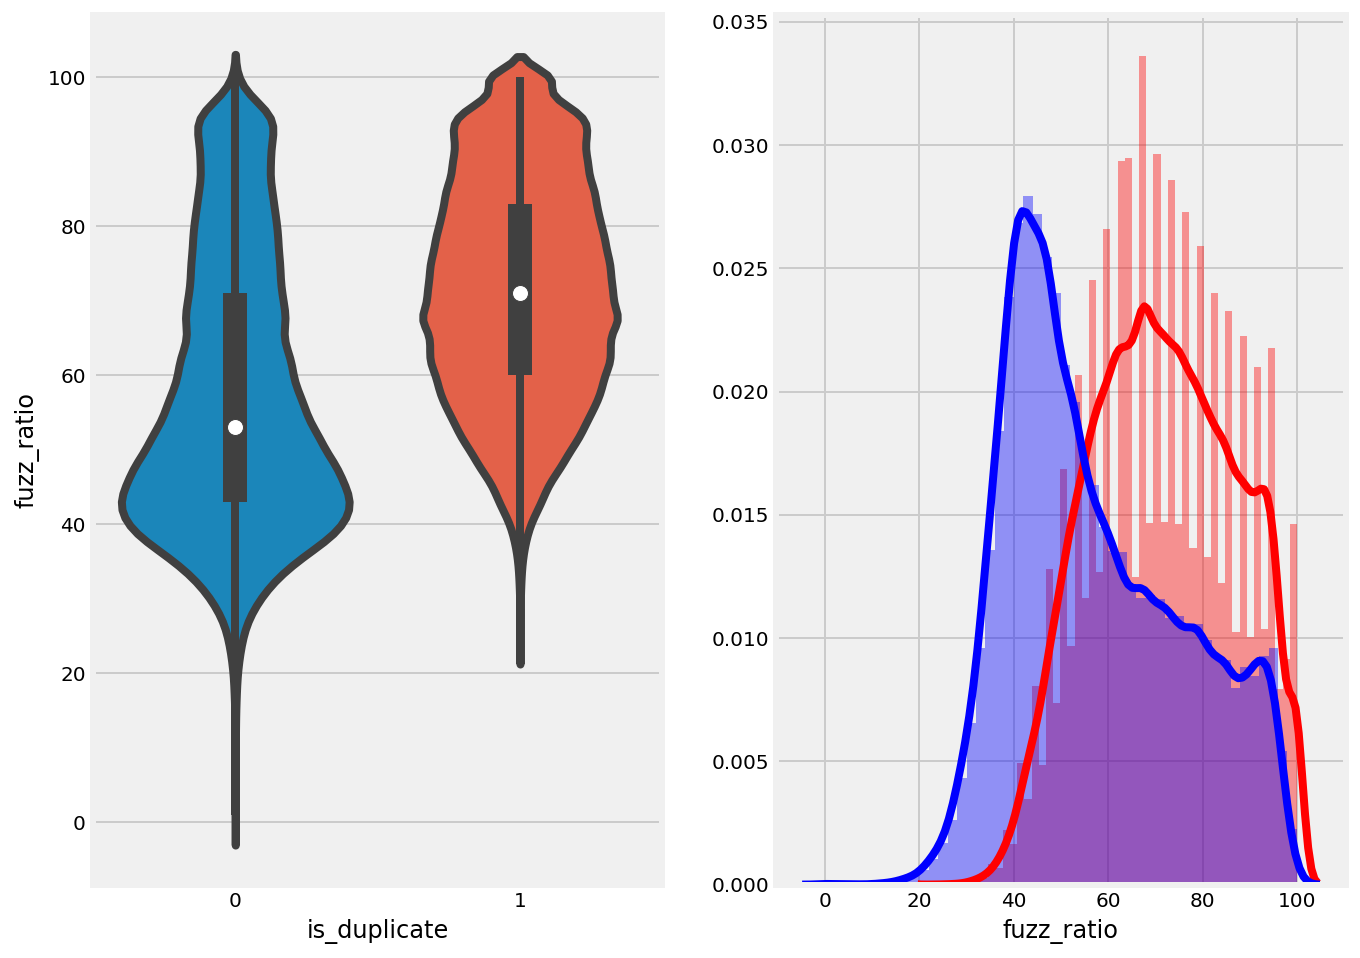

In [5]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = train[0:] , )
plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

#### fuzz_partial_ratio

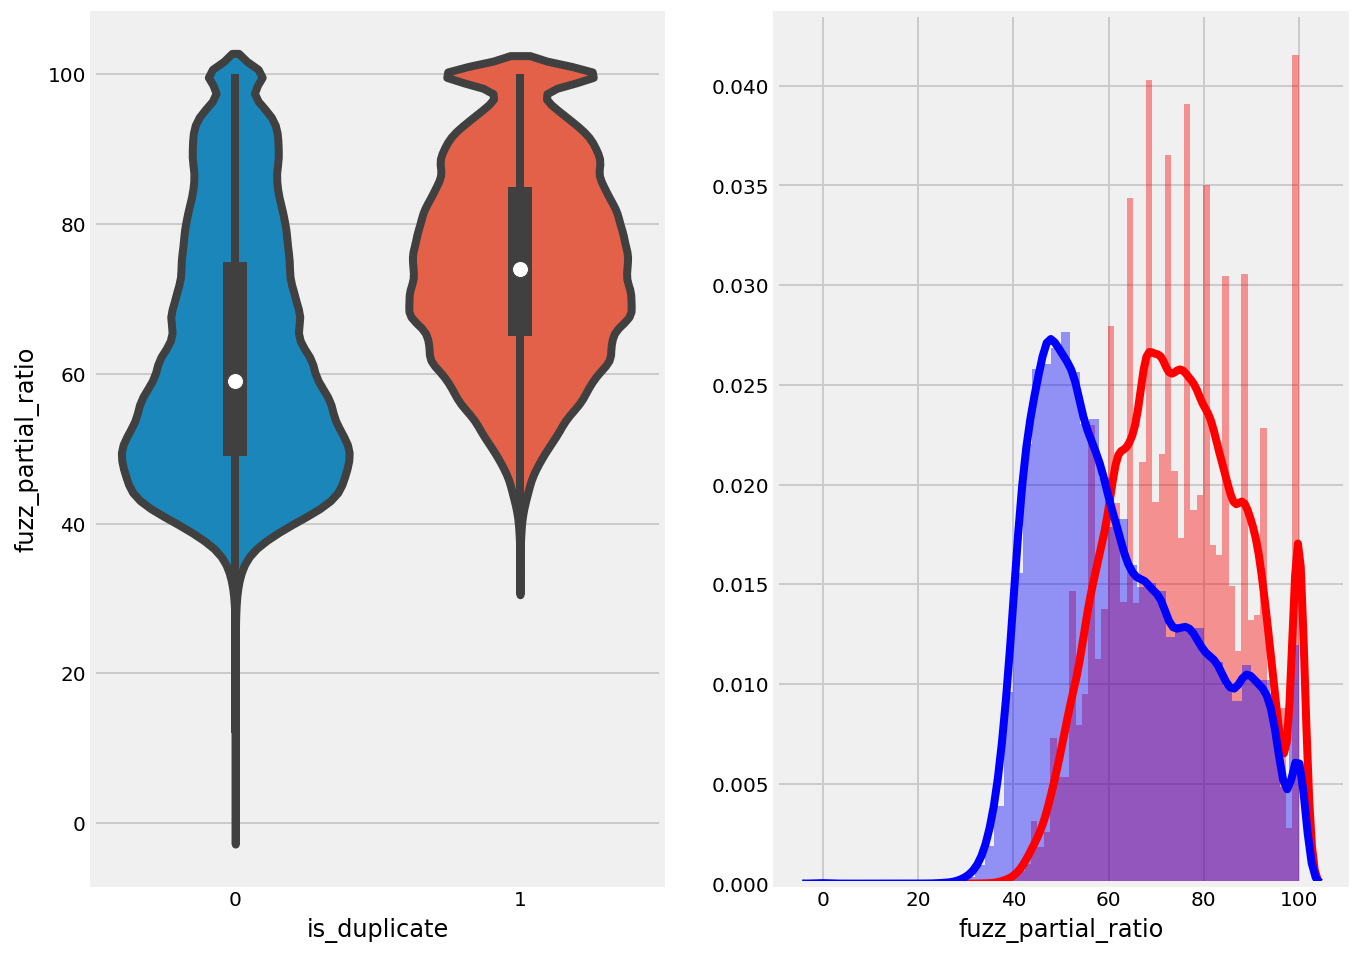

In [6]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = train[0:] , )
plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

#### token_sort_ratio

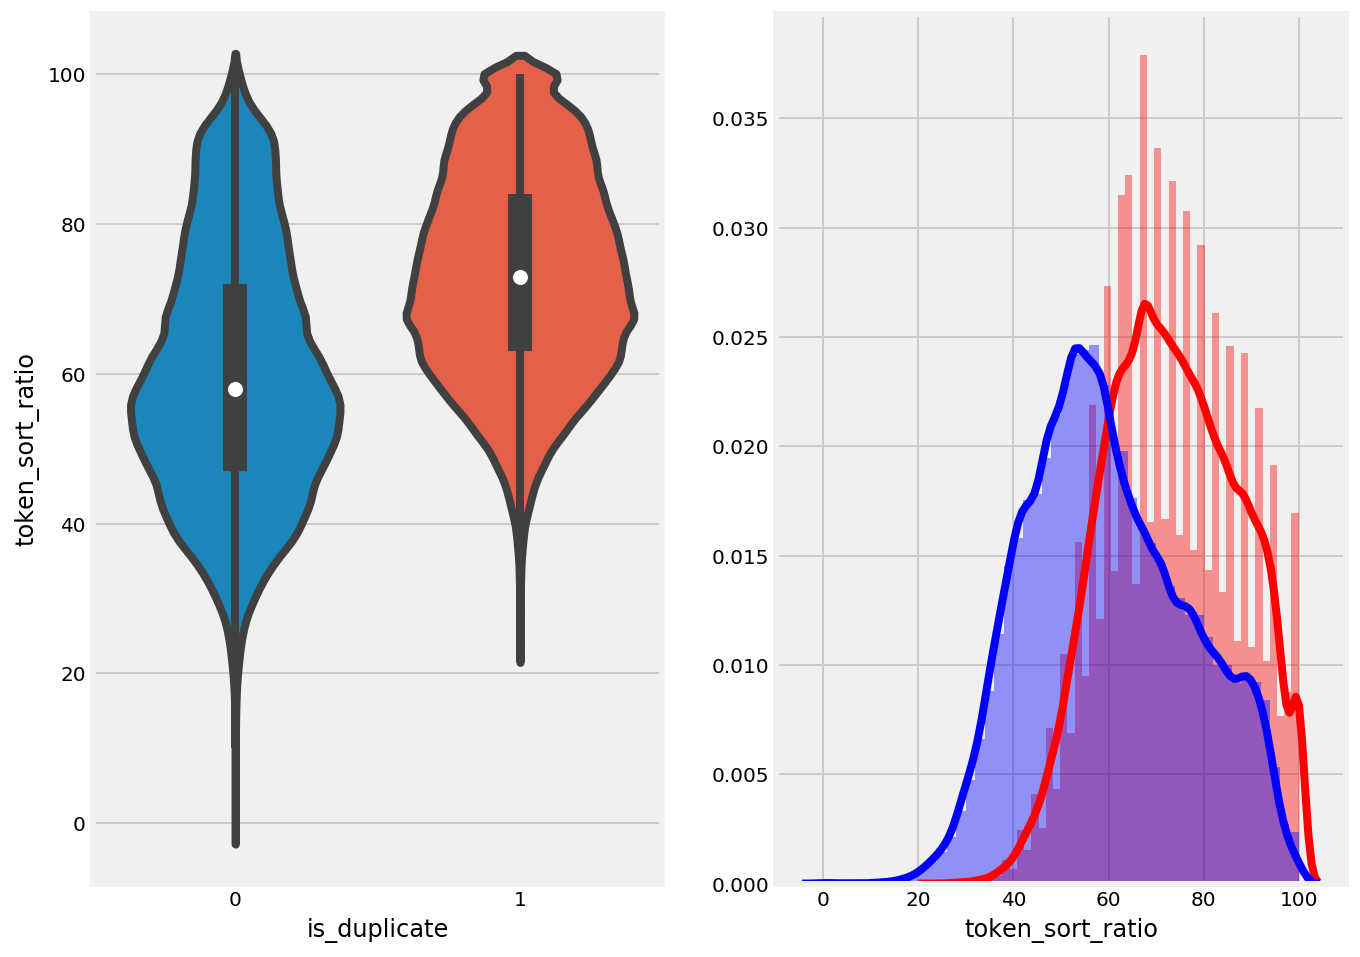

In [7]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = train[0:] , )
plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

#### token_set_ratio

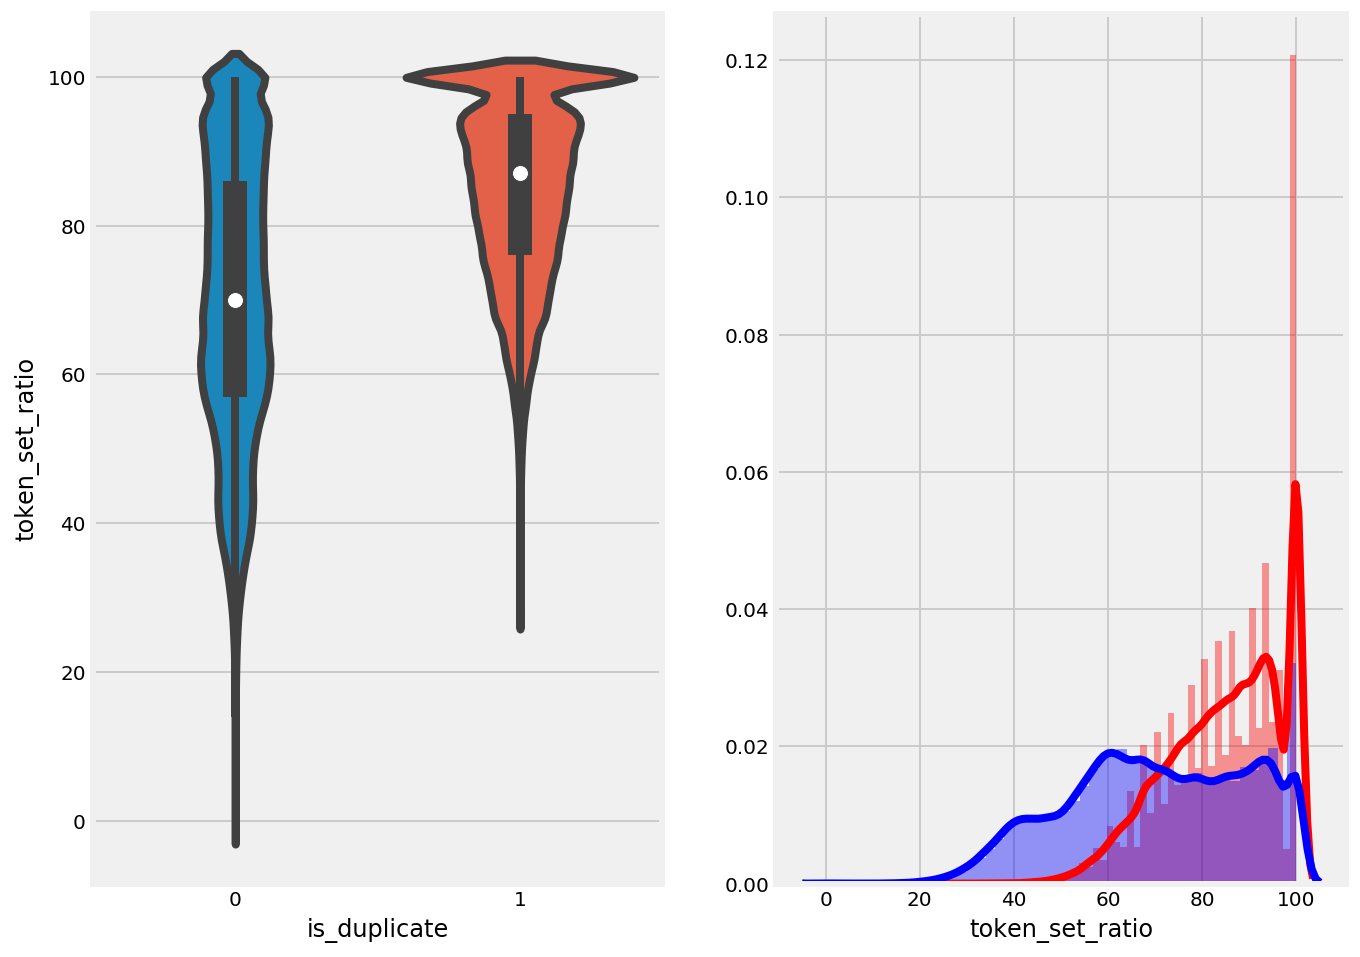

In [8]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = train[0:] , )
plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

#### longest_substr_ratio

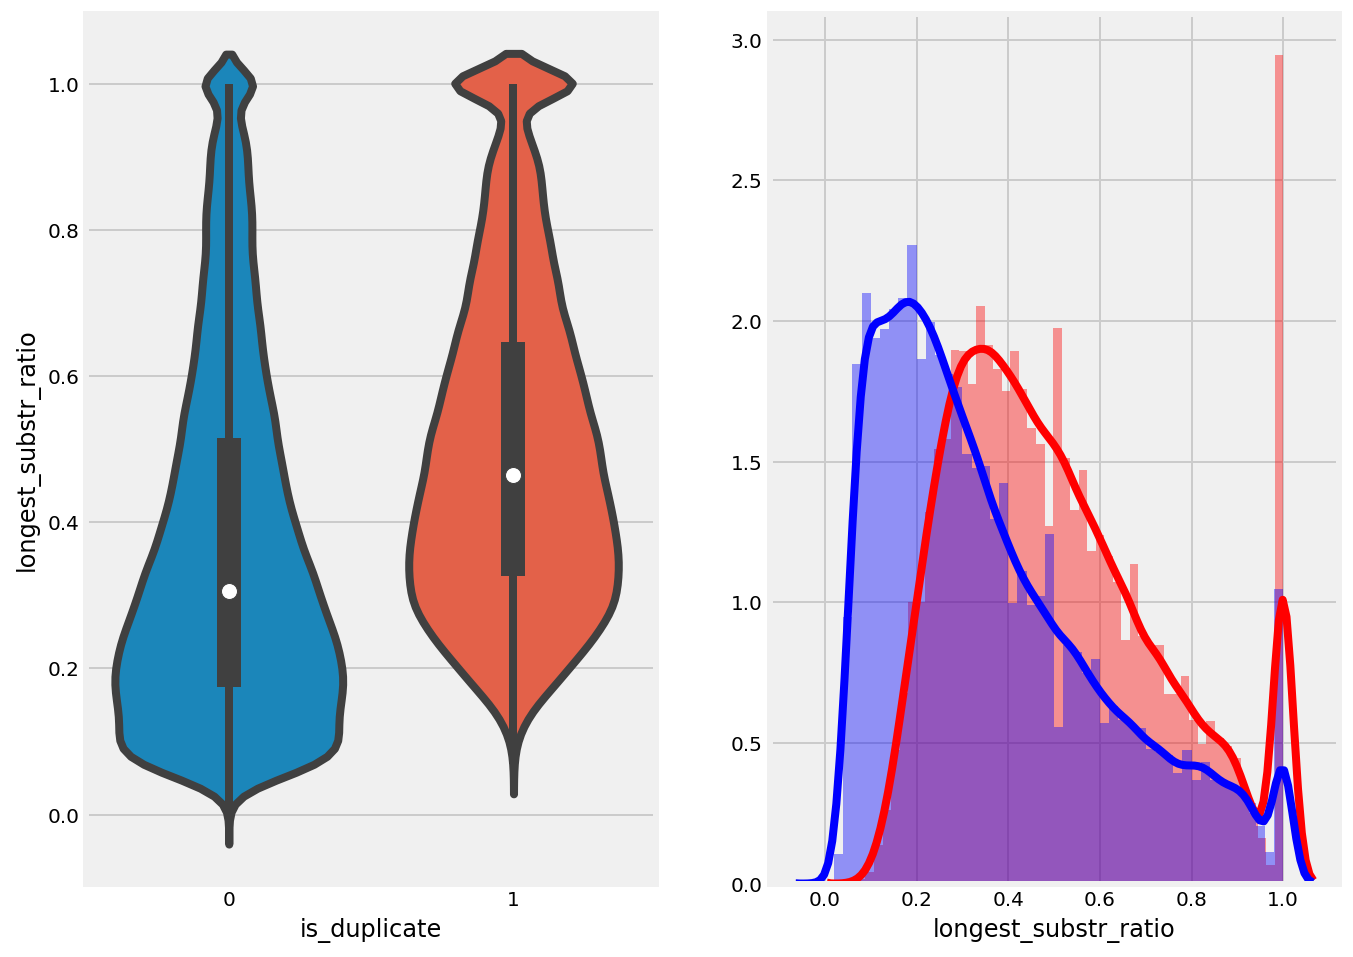

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = train[0:] , )
plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['longest_substr_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['longest_substr_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

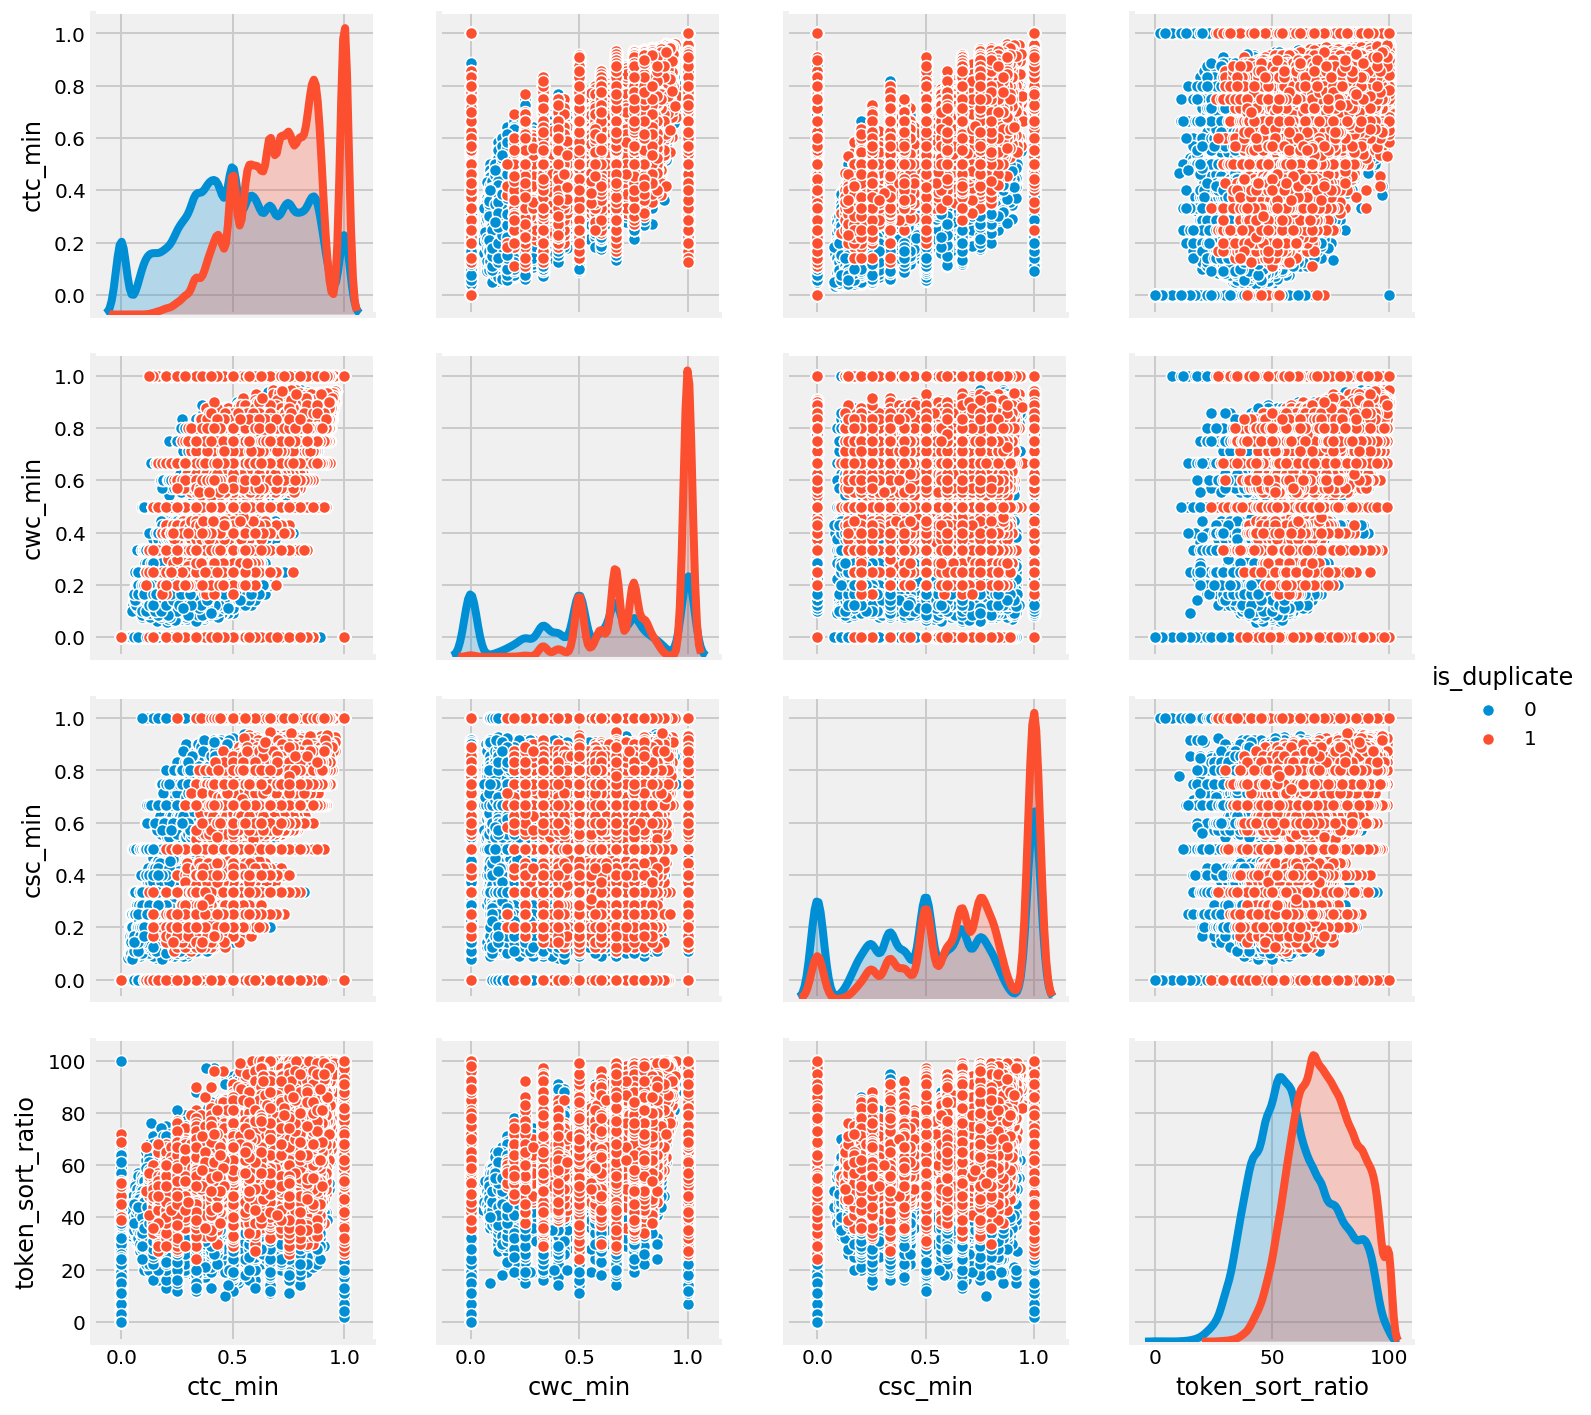

In [13]:
sns.pairplot(train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], 
             hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

**Note:** `ctc_min`, `cwc_min` and `csc_min` are not powerful indivisually as we can in diagonal distribution plots but we can see that their interactions are able to separate class labels to some extent. This means these features would do okay when used in combinations

### 11. Word2Vec on Questions on pretrained w2v

In [13]:
from pyemd import emd
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/home/paperspace/w2v/GoogleNews-vectors-negative300.bin',
                                         binary=True)

In [5]:
model.vectors[model.vectors == 0]

array([], dtype=float32)

In [34]:
model.__contains__('mayukh')

False

In [14]:
def sent2vec(s):
    words = tokenizer.tokenize(s)
    words = {each for each in words if each not in ENGLISH_STOP_WORDS}
    V = []
    for word in words:
        if model.__contains__(word):
            V.append(model[word])
    V = np.array(V)
    if V.shape[0] == 0:
        return np.zeros(300)
    V = V.sum(axis=0)
    return V / np.sqrt((V ** 2).sum())

In [18]:
question1_vectors = np.zeros((train.shape[0], 300))
for i, q in tqdm(enumerate(train.question1.values)):
    question1_vectors[i, :] = sent2vec(q)

404289it [00:19, 20599.74it/s]


In [19]:
question2_vectors  = np.zeros((train.shape[0], 300))
for i, q in tqdm(enumerate(train.question2.values)):
    question2_vectors[i, :] = sent2vec(q)

404289it [00:19, 20783.61it/s]


### 12. Text Similarity Features

**Refer:** https://www.linkedin.com/pulse/duplicate-quora-question-abhishek-thakur/

#### Word Mover Distance

In [7]:
def wmd(s1, s2):
    s1 = tokenizer.tokenize(s1)
    s2 = tokenizer.tokenize(s2)
    s1 = [w for w in s1 if w not in ENGLISH_STOP_WORDS]
    s2 = [w for w in s2 if w not in ENGLISH_STOP_WORDS]
    return model.wmdistance(s1, s2)

In [11]:
train['wmd'] = train.progress_apply(lambda row: wmd(row.question1, row.question2), axis=1)

100%|██████████| 404289/404289 [05:09<00:00, 1307.10it/s]


#### Cosine distance

In [32]:
from scipy.spatial.distance import cosine

In [ ]:
train['cosine_distance'] = [cosine(x, y) for x, y in zip(question1_vectors, question2_vectors)]

#### cityblock_distance

In [38]:
from scipy.spatial.distance import cityblock

In [41]:
train['cityblock_distance'] = [cityblock(x, y) for x, y in zip(question1_vectors, question2_vectors)]

#### Jaccard distance 

In [43]:
from scipy.spatial.distance import jaccard

In [ ]:
train['jaccard_distance'] = [jaccard(x, y) for x, y in zip(question1_vectors, question2_vectors)]

#### canberra_distance

In [45]:
from scipy.spatial.distance import canberra

In [46]:
train['canberra_distance'] = [canberra(x, y) for x, y in zip(question1_vectors, question2_vectors)]

#### euclidean_distance

In [23]:
from scipy.spatial.distance import euclidean

In [24]:
train['euclidean_distance'] = [euclidean(x, y) for x, y in zip(question1_vectors, question2_vectors)]

#### minkowski_distance

In [20]:
from scipy.spatial.distance import minkowski

In [21]:
train['minkowski_distance'] = [minkowski(x, y, 3) for x, y in zip(question1_vectors, question2_vectors)]

#### braycurtis_distance

In [52]:
from scipy.spatial.distance import braycurtis

In [ ]:
train['braycurtis_distance'] = [braycurtis(x, y) for x, y in zip(question1_vectors, question2_vectors)]

#### Skew and Kurtosis

In [54]:
from scipy.stats import skew, kurtosis

In [ ]:
train['skew_q1vec'] = [skew(x) for x in question1_vectors]
train['skew_q2vec'] = [skew(x) for x in question2_vectors]
train['kur_q1vec'] = [kurtosis(x) for x in question1_vectors]
train['kur_q2vec'] = [kurtosis(x) for x in question2_vectors]

### Checkpoint 4

In [26]:
conn = sqlite3.connect('dataset/Cleaned.db')
train.to_sql('train', conn, if_exists='replace', index=False)
conn.close()

In [36]:
np.save('dataset/question1_vectors.npy', question1_vectors)
np.save('dataset/question2_vectors.npy', question2_vectors)

### TSNE Visualisation

In [2]:
with sqlite3.connect('dataset/Cleaned.db') as conn:
    train = pd.read_sql_query('SELECT * FROM train', conn)

In [3]:
train.shape

(404289, 46)

In [4]:
train.dropna(inplace=True)

In [5]:
train.shape

(402810, 46)

In [6]:
labels = train.is_duplicate

In [7]:
train.drop([
    'id',
    'qid1',
    'qid2',
    'question1',
    'question2',
    'is_duplicate'
], inplace=True, axis=1)

In [9]:
train.shape

(402810, 40)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
sclr = MinMaxScaler()

In [12]:
X = sclr.fit_transform(train)

/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [15]:
from sklearn.decomposition import PCA

In [16]:
X.shape

(402810, 40)

In [17]:
pca = PCA(n_components=X.shape[1], random_state=42)

In [18]:
X_pca = pca.fit_transform(X)

In [22]:
tsne = TSNE(n_jobs=12, verbose=2, n_components=2, random_state=42)

In [23]:
tsne_X = tsne.fit_transform(X_pca)  # 2827 seconds on 12 core 30GB RAM

In [24]:
tsne_X.shape

(402810, 2)

In [25]:
tsne_X = pd.DataFrame(tsne_X)

In [26]:
tsne_X['label'] = labels
tsne_X.columns = ['axis1', 'axis2', 'label']

In [27]:
plt.rcParams['figure.figsize'] = [12, 12]

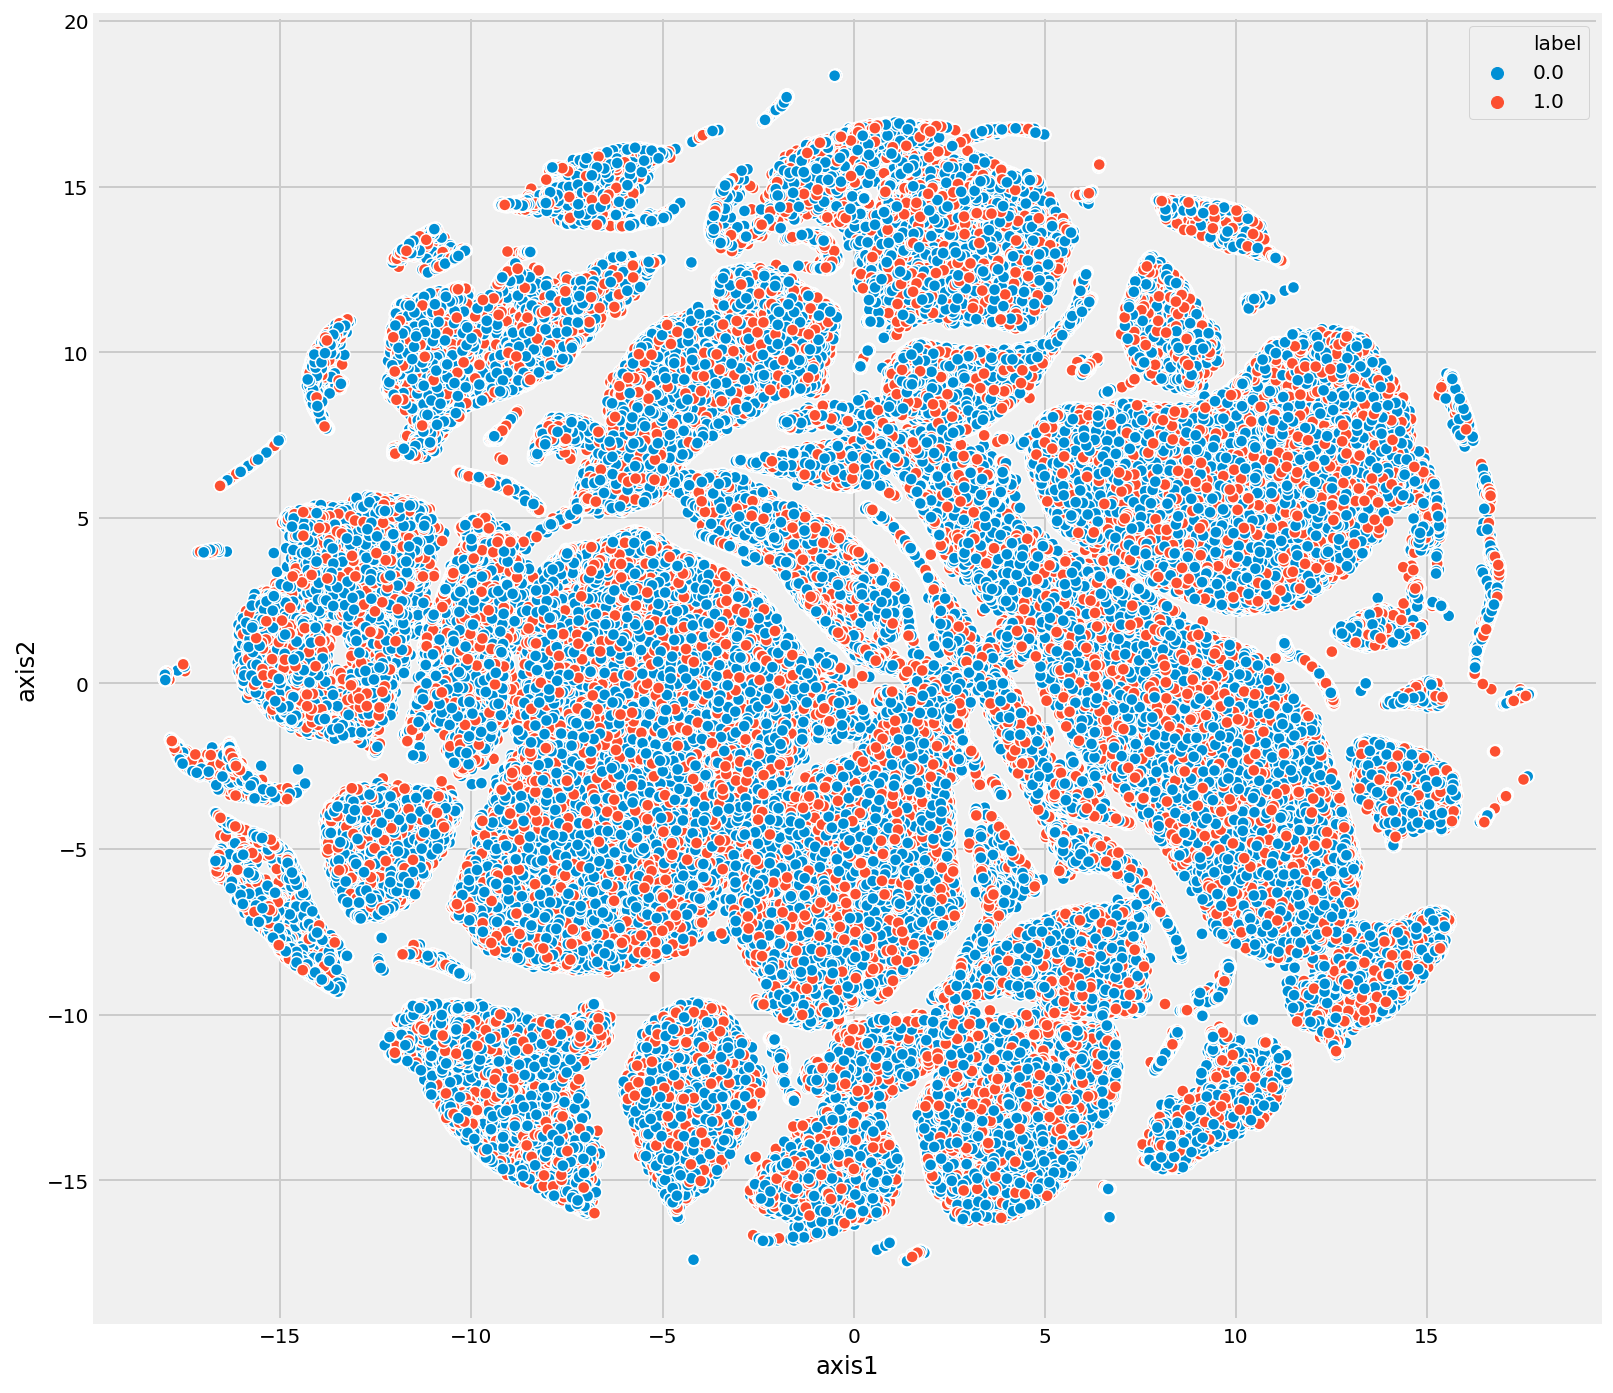

In [28]:
sns.scatterplot(x='axis1', y='axis2', data=tsne_X, hue='label');

In [30]:
tsne_X.to_sql('train_tsne', conn, index=False, if_exists='replace')

In [31]:
conn.close()